In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

General outlook: 

* Current season and historical scoring -> swarm plot of points at each game

    * Distribution of points from locations compared with those other top scorers (2pt/3pt/FT)
    
    * Compare how many field goals which he made were assisted/unassisted with this year/historic players
    
    * Compare free throw shooting with other players.
    
    * Step backs comparison (like with Doncic)
    
    * Step backs shot chart
    
    * Shotchart for this year
    
        
* Evolution of Harden

    * Shotchart through time would be nice to see
    
    * How his usage rose through time
    
    * Change in style from OKC to HOU
    
    
* Comparsion with Phoenix' system with D'Antoni

    * Compare Harden with Steve Nash
    
    * Shot charts comparison

* Parallel plot

    * Play type (post up, drive, catch & shoot, ...)
    
    * Shots from distances various

* Speed and distance

    * Plot correlation of speed and distance, and add in number of dribbles
   
* Take a look at passing and touches

    * Number of touches and dribbles by Harden
    
    * Number of passes by Houston as a team in comparison with all other teams
    
    * How the passes are shared in team (graph chart/network chart / heatmap)

## Setup

In [2]:
from nba_api.stats.static.players import find_players_by_full_name

In [3]:
harden_data = find_players_by_full_name("James Harden")

In [4]:
harden_id = harden_data[0]['id']

## Analyzing shooting splits

In [14]:
import time

In [5]:
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits

In [11]:
int_seasons = list(range(2009, 2019))

In [32]:
harden_shot_types_df = None
harden_overall_df = None
seasons = list()
for i in range(len(int_seasons)):
    season_str = str(int_seasons[i]) + "-" + str(int_seasons[i]+1)[-2:]
    data_frames = PlayerDashboardByShootingSplits(
            player_id=harden_id,
            season=season_str).get_data_frames()
    shot_type_detail = data_frames[-2]
    shot_type_detail.loc[:, 'SEASON'] = season_str
    overall = data_frames[0]
    overall.loc[:, 'SEASON'] = season_str
    time.sleep(1)
    if harden_shot_types_df is None:
        harden_shot_types_df = shot_type_detail
        harden_overall_df = overall
    else:
        harden_shot_types_df = harden_shot_types_df.append(shot_type_detail, ignore_index=True)
        harden_overall_df = harden_overall_df.append(overall, ignore_index=True)

In [44]:
step_backs = harden_shot_types_df.loc[harden_shot_types_df.GROUP_VALUE == 'Step Back Jump shot']

In [40]:
plt.style.use('seaborn')

In [48]:
step_backs.FGA.tolist()

[2, 15, 17, 70, 147, 191, 199, 155, 267, 375]

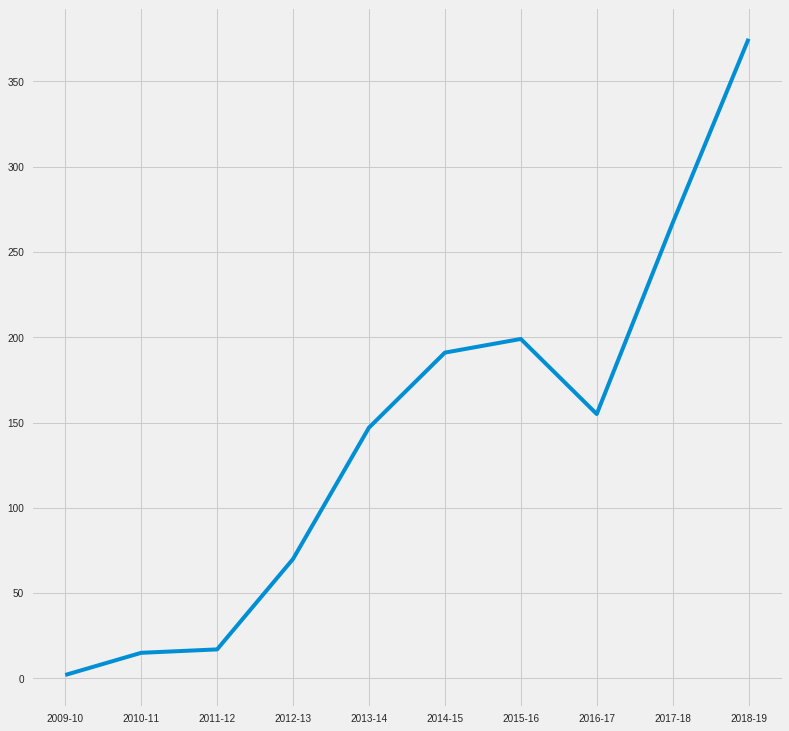

In [64]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot('SEASON', 'FGA', data=step_backs)


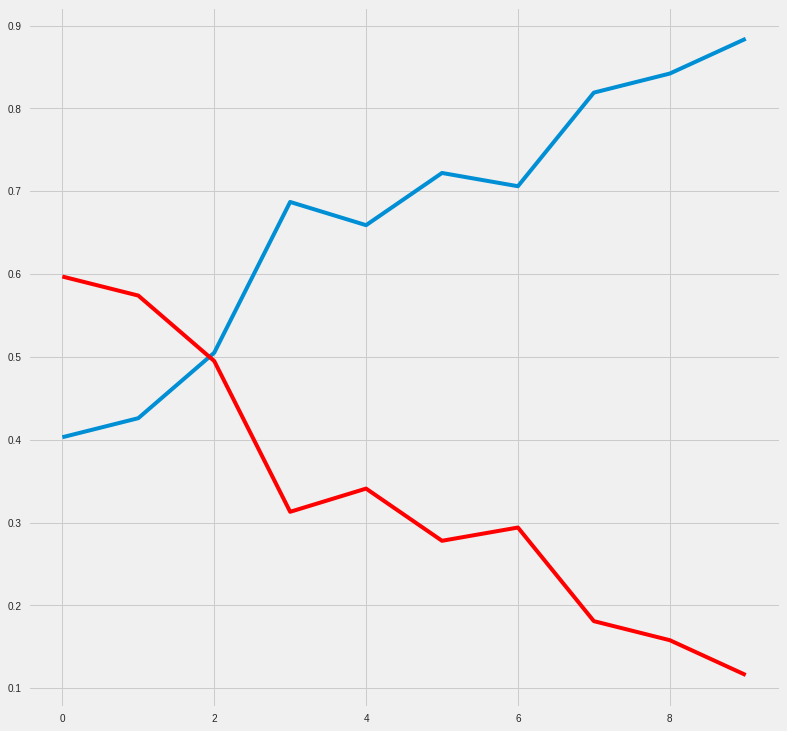

In [60]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(harden_overall_df.PCT_UAST_FGM)
ax.plot(harden_overall_df.PCT_AST_FGM, color='r')

## Comparison with historic top scorers

In [5]:
import requests
from bs4 import BeautifulSoup

In [7]:
def get_urls_for_top_scorers(url):
    res = requests.get(top_scorers_url)
    soup = BeautifulSoup(res.text)
    item = soup.find(attrs={'class': 'stats_table'})
    rows = item.findAll("tr")
    urls = list()
    for row in rows:
        header_cells = row.findAll("th")
        for header_cell in header_cells:
            if 'data-stat' in header_cell.attrs and header_cell['data-stat'] == 'ranker' and 'csk' in header_cell.attrs:
                rank = int(header_cell.getText())
        td_cells = row.findAll("td")
        if not td_cells:
            continue
        for cell in td_cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'season':
                season = int(cell.getText().split("-")[0])+1
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'player':
                url = cell.findAll("a")[0]['href']
        game_log_url = bbref_base + url.split(".")[0] + "/gamelog/" + str(season)
        urls.append(game_log_url)
    return urls

In [25]:
import re

def get_player_name_points(url, limit):
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    title = soup.find('h1').getText()
    splitted = re.split('\d{4}-\d{2}', title)
    name = splitted[0].strip()
    dash_splitted = title.split('-')
    season = dash_splitted[0].split(" ")[-1] + "-" + dash_splitted[1].split(" ")[0]
    player_names = list()
    seasons = list() # this will be filled with same values
    points = list()
    
    rows = soup.findAll('tr')
    for row in rows:
        cells = row.findAll('td')
        for cell in cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'reason':
                continue
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'game_season':
                if cell.getText() == "":
                    continue
                if int(cell.getText()) > limit:
                    break
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'pts':
                points.append(int(cell.getText()))
                player_names.append(name)
                seasons.append(season)
    
    return player_names, seasons, points

In [12]:
url = 'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019'
names, seasons, points = get_player_name_points(url)

In [20]:
top_scorers_urls = [
    'https://www.basketball-reference.com/players/j/jordami01/gamelog/1987',
    'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019',
    'https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006',
    'https://www.basketball-reference.com/players/i/iversal01/gamelog/2006',
    'https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003',
    'https://www.basketball-reference.com/players/d/duranke01/gamelog/2014',
    'https://www.basketball-reference.com/players/w/westbru01/gamelog/2017',
    'https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006',
]

In [29]:
import time
full_names, full_seasons, full_points = [], [], []
harden_total_games = 51
for url in top_scorers_urls:
    print(f"Current url: {url}")
    names, seasons, points = get_player_name_points(url, limit=harden_total_games)
    time.sleep(0.5)
    full_names.extend(names)
    full_seasons.extend(seasons)
    full_points.extend(points)

data_frame = pd.DataFrame(data={
    'PLAYER': full_names,
    'SEASON': full_seasons,
    'POINTS': full_points
})

Current url: https://www.basketball-reference.com/players/j/jordami01/gamelog/1987
Current url: https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019
Current url: https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006
Current url: https://www.basketball-reference.com/players/i/iversal01/gamelog/2006
Current url: https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003
Current url: https://www.basketball-reference.com/players/d/duranke01/gamelog/2014
Current url: https://www.basketball-reference.com/players/w/westbru01/gamelog/2017
Current url: https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006


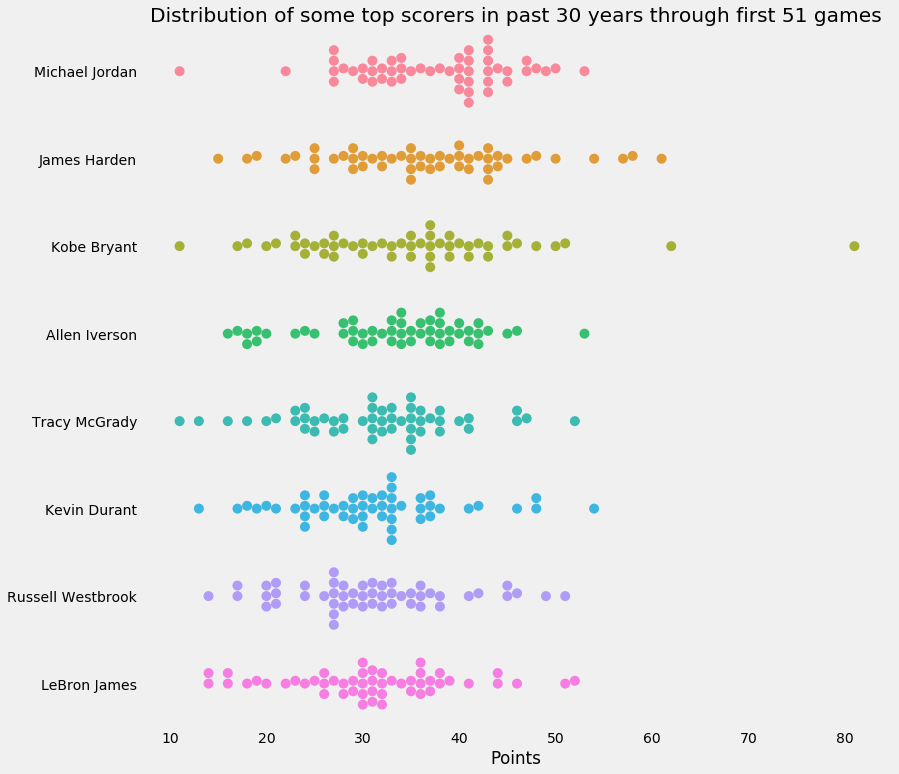

In [59]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.swarmplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax, size=10)
ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 51 games')

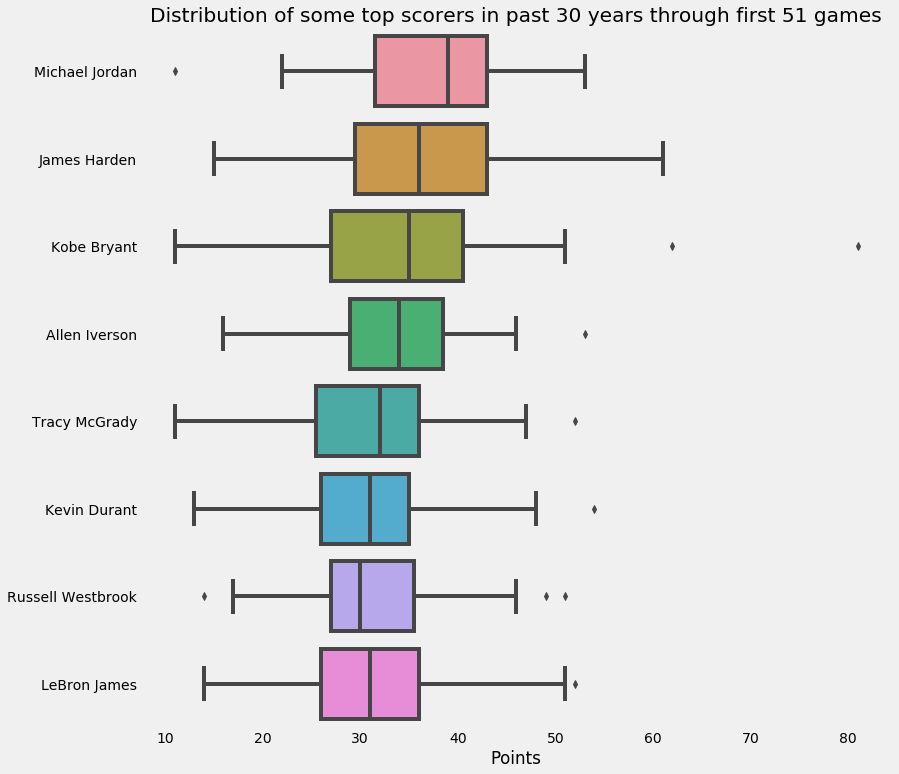

In [60]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.boxplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax)
ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 51 games')

## Unassisted vs assisted Field goals

In [5]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [6]:
base_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base', per_mode_detailed='Totals')

In [7]:
base_df = base_stats.get_data_frames()[0]

In [8]:
scoring_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring')
scoring_df = scoring_stats.get_data_frames()[0]

In [9]:
base_df.loc[:, 'PTS_G'] = base_df.PTS / base_df.GP

In [10]:
base_df = base_df.sort_values(by='PTS', ascending=False)

In [11]:
merged_df = pd.merge(base_df, scoring_df, how='inner', on='PLAYER_ID')

interesting keys: 'PTS', 'FGM', 'FGA', '3FGM', '3FGA', 'PCT_UAST_FGM', 'PCT_AST_FGM'

In [12]:
def calculate_total_uast_ast(data_frame):
    data_frame.loc[:, 'UAST_FGM'] = (data_frame.FGM * data_frame.PCT_UAST_FGM).astype(int, errors='ignore')
    data_frame.loc[:, 'AST_FGM'] = (data_frame.FGM * data_frame.PCT_AST_FGM).astype(int, errors='ignore')
    
    data_frame.loc[:, 'UAST_FG3M'] = (data_frame.FG3M * data_frame.PCT_UAST_3PM).astype(int, errors='ignore')
    data_frame.loc[:, 'AST_FG3M'] = (data_frame.FG3M * data_frame.PCT_AST_3PM).astype(int, errors='ignore')
    
    
    return data_frame

In [13]:
total_merged_df = calculate_total_uast_ast(merged_df)

In [14]:
top_150_scorers_df = total_merged_df.iloc[:250]

In [15]:
top_scorers = top_150_scorers_df.iloc[:15]

In [16]:
from adjustText import adjust_text

Text(0.5, 1.0, 'Unassisted vs assisted field goals made for 2018-19 season')

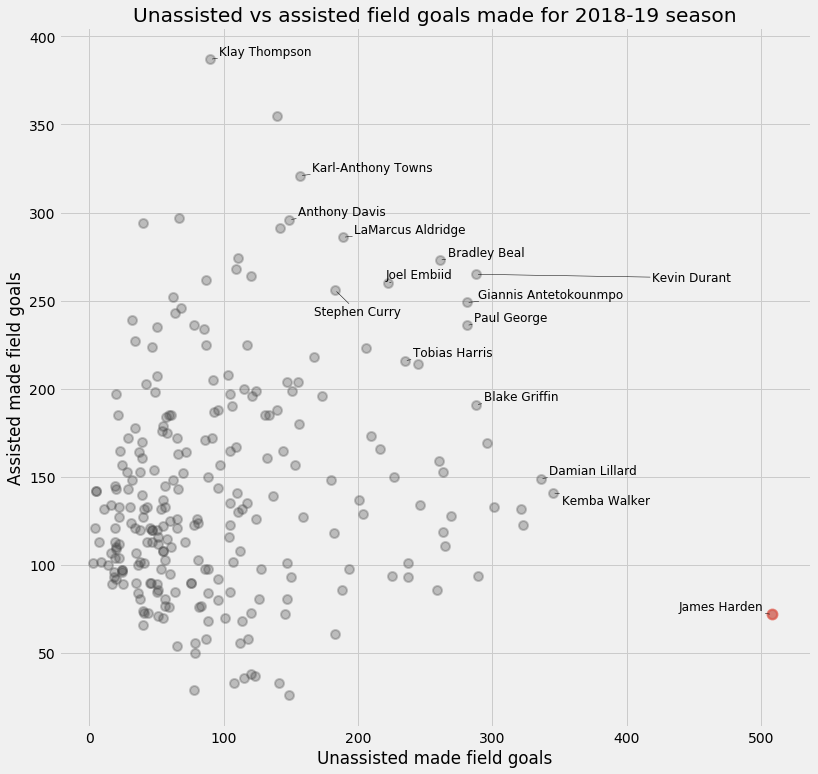

In [17]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=top_150_scorers_df.UAST_FGM, y=top_150_scorers_df.AST_FGM, s=80, color="#454545", alpha=0.3, linewidths=2)

texts = []
for i in range(len(top_scorers)):
    item = top_scorers.iloc[i]
    texts.append(ax.text(x=item.UAST_FGM, y=item.AST_FGM, s=item.PLAYER_NAME_x, fontsize=12))
    if item.PLAYER_NAME_x == 'James Harden':
        ax.scatter(x=item.UAST_FGM, y=item.AST_FGM, s=100, color="#EA5545", alpha=0.6, linewidths=2.0)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), expand_points=(1.2, 1.2), expand_text=(1.3, 1.3))

ax.set_xlabel("Unassisted made field goals")
ax.set_ylabel("Assisted made field goals")
ax.set_title("Unassisted vs assisted field goals made for 2018-19 season")

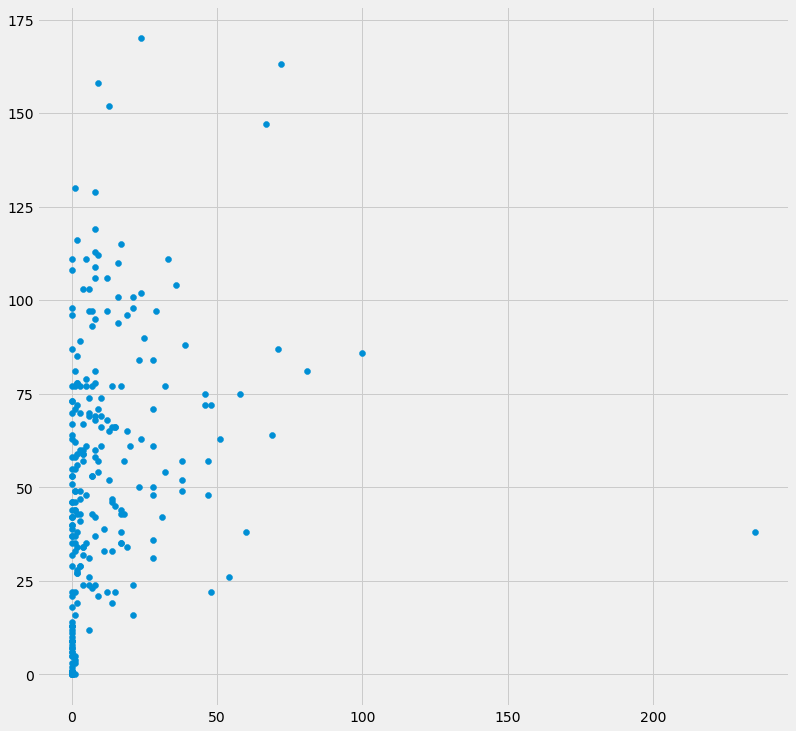

In [18]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=top_150_scorers_df.UAST_FG3M, y=top_150_scorers_df.AST_FG3M)

Maybe add in comparison with top scorers in last 10-15 years (15 years, top 10 players is ok)

## Usage and efficiency

While Harden is having tremendously high scoring season, how efficient is he? And how big is his usage? I'll take on that in next couple of cells.

In [19]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [20]:
basic_stats = LeagueDashPlayerStats()
basic_df = basic_stats.get_data_frames()[0]

In [21]:
advanced_stats = LeagueDashPlayerStats(measure_type_detailed_defense="Advanced")

In [22]:
advanced_df = advanced_stats.get_data_frames()[0]

In [23]:
advanced_df_filtered = advanced_df.loc[advanced_df.GP > 20]

In [24]:
advanced_df_filtered = advanced_df_filtered.sort_values(by="USG_PCT", ascending=False)

In [25]:
from numpy.polynomial.polynomial import polyfit

In [26]:
merged_df = pd.merge(basic_df, advanced_df, on='PLAYER_ID')

In [27]:
filtered_data = merged_df.sort_values(by='PTS', ascending=False)
filtered_data = filtered_data.iloc[:200]

In [28]:
filter_out_harden = filtered_data.loc[filtered_data.PLAYER_NAME_x == 'James Harden']

In [29]:
from adjustText import adjust_text

Text(0.5, 1.0, 'Efficiency based on usage for 2018-19 season')

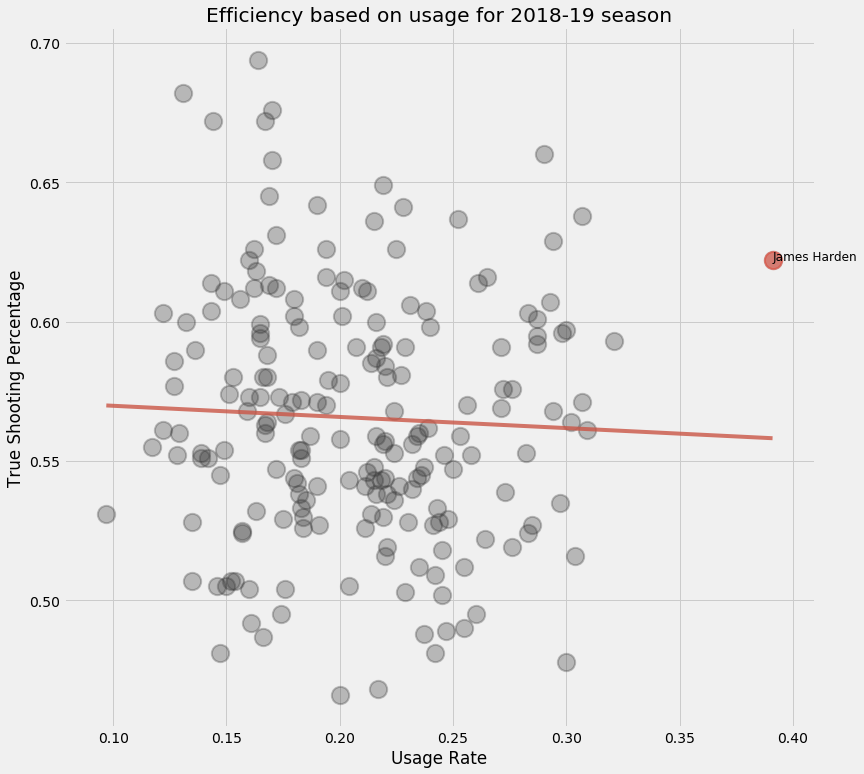

In [30]:

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))


ax.scatter(x=filtered_data.USG_PCT, y=filtered_data.TS_PCT, s=300, alpha=0.3, linewidths=2.0, color="#343434")

ax.scatter(x=filter_out_harden.USG_PCT, y=filter_out_harden.TS_PCT, s=300, linewidths=2.0, color="#EA5545", alpha=0.6)
text = [ax.text(x=filter_out_harden.USG_PCT.iloc[0], y=filter_out_harden.TS_PCT.iloc[0], s="James Harden", fontsize=12)]


ax.set_xlabel('Usage Rate')
ax.set_ylabel('True Shooting Percentage')
ax.set_title('Efficiency based on usage for 2018-19 season')

### Top scorers in three point era

Here I took a look at top 100 scorers in three point era, and how they efficient they were with more workload on their back.

In [37]:
data_frame = pd.read_csv('top_100_3pt_era.csv')

In [38]:
harden_only = data_frame.loc[(data_frame.Player == 'James Harden') & (data_frame.Season == '2018-19')]

In [39]:
from numpy.polynomial.polynomial import polyfit

In [40]:
usages = np.array(data_frame.USG_PCT)
square_usages = usages ** 2

b, m1 = polyfit(data_frame.USG_PCT, data_frame.TS_PCT, deg=1)

In [41]:
x_usages = np.linspace(int(data_frame.USG_PCT.min()), int(data_frame.USG_PCT.max())+1, 100)

Text(0.5, 1.0, 'Efficiency of top 100 scorers since 1979-80')

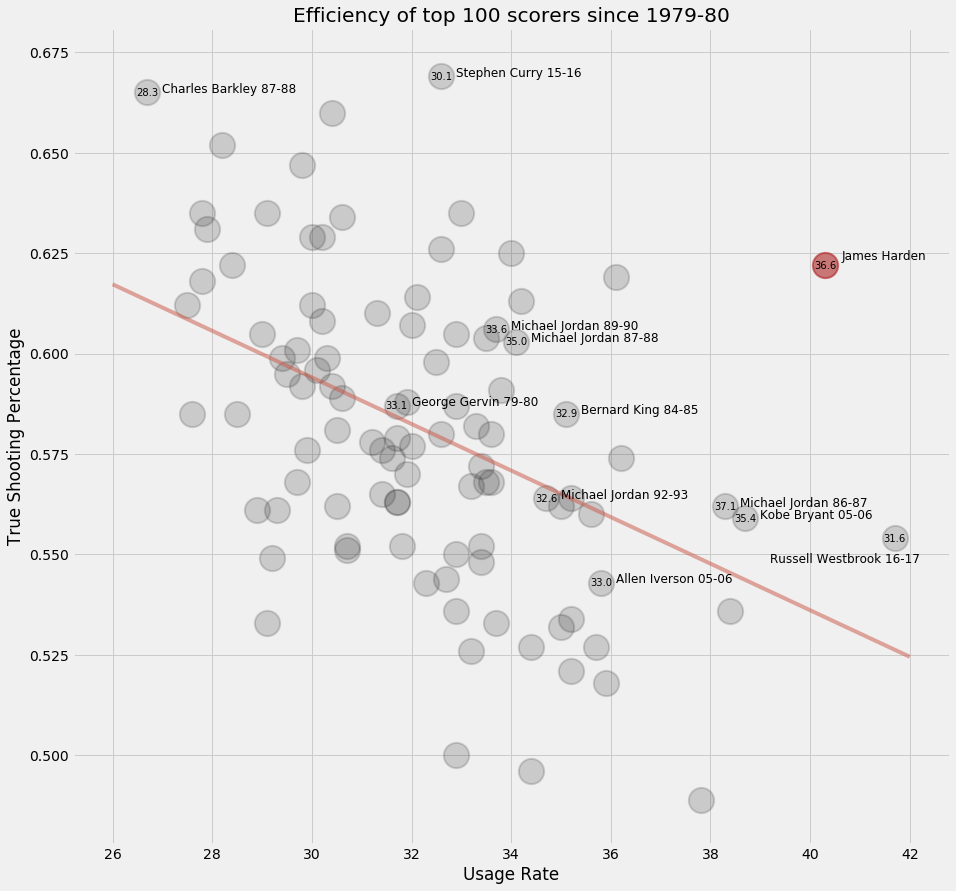

In [75]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(14, 14))


ax.plot(x_usages, b + m1 * x_usages, color="#CA5545", alpha=0.5)

texts=[]
for i in range(len(data_frame)):
    item = data_frame.iloc[i]
    if item.Player == 'James Harden' and item.Season == '2018-19':
        ax.scatter(x=item.USG_PCT, y=item.TS_PCT, s=640, linewidths=2.0, color="#AE2525", alpha=0.6)
        text = [ax.text(x=item.USG_PCT, y=item.TS_PCT, s="James Harden", fontsize=12)]
        ax.text(x=item.USG_PCT, y=item.TS_PCT, s=item.PTS, fontsize=10, ha='center', va='center')
        continue
    ax.scatter(x=item.USG_PCT, y=item.TS_PCT, s=640, alpha=0.2, linewidths=2.0, color="#343434")
    if item.Rk < 10 or item.TS_PCT > 0.66 or item.USG_PCT > 40:
        season = item.Season[-5:]
        name = item.Player
        points = item.PTS
        if name == "Russell Westbrook":
            texts.append(ax.text(x=item.USG_PCT + - 2.5, y=item.TS_PCT -0.006, s=name + " " + season, fontsize=12))
        else:
            texts.append(ax.text(x=item.USG_PCT + 0.3, y=item.TS_PCT, s=name + " " + season, fontsize=12))
        ax.text(x=item.USG_PCT, y=item.TS_PCT, s=points, fontsize=10, ha='center', va='center')
# ax.scatter(x=data_frame.USG_PCT, y=data_frame.TS_PCT, s=500, alpha=0.2, linewidths=2.0, color="#343434")

# ax.scatter(x=harden_only.USG_PCT, y=harden_only.TS_PCT, s=500, linewidths=2.0, color="#CA5545")
# text = [ax.text(x=harden_only.USG_PCT.iloc[0], y=harden_only.TS_PCT.iloc[0], s="James Harden", fontsize=12)]
adjust_text(texts=text, expand_points=(1.4, 1.4), autoalign='xy')
# ax.text(x=harden_only.USG_PCT.iloc[0], y=harden_only.TS_PCT.iloc[0], s=harden_only.PTS.iloc[0], fontsize=10, ha='center', va='center')

ax.set_xlabel('Usage Rate')
ax.set_ylabel('True Shooting Percentage')
ax.set_title('Efficiency of top 100 scorers since 1979-80')

# Touches and possession time

In [43]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats

In [52]:
touches = LeagueDashPtStats(per_mode_simple="PerGame", pt_measure_type="Possessions", player_or_team='Player')

In [53]:
touches_df = touches.get_data_frames()[0]

In [49]:
touches_df.columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GP', 'W', 'L', 'MIN',
       'POINTS', 'TOUCHES', 'FRONT_CT_TOUCHES', 'TIME_OF_POSS',
       'AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH', 'PTS_PER_TOUCH',
       'ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES', 'PTS_PER_ELBOW_TOUCH',
       'PTS_PER_POST_TOUCH', 'PTS_PER_PAINT_TOUCH'],
      dtype='object')

In [106]:
touches_df = touches_df.loc[touches_df.GP > 20]
touches_df = touches_df.loc[touches_df.GP * touches_df.TOUCHES > 500]

In [107]:
without_harden = touches_df.loc[touches_df.PLAYER_NAME != "James Harden"]

ADD HOUSTON AS SPECIFIC COLOR

Text(7.21, 0.4, 'Marker size represents\npoints per game\nthrough season.\nGenerally points fall\nas dribbles rise.')

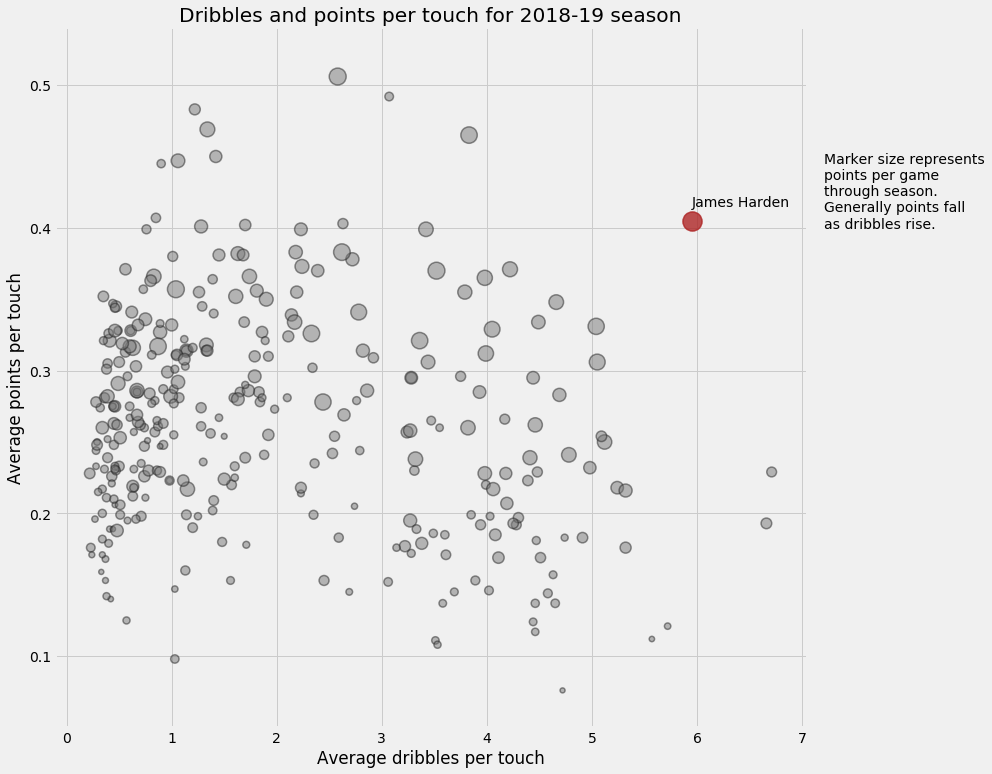

In [125]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(
    x=without_harden.AVG_DRIB_PER_TOUCH,
    y=without_harden.PTS_PER_TOUCH,
    s=without_harden.POINTS*10,
    alpha=0.5,
    color="#787878",
    edgecolors="#232323",
    linewidths=1.5,
)

harden_df = touches_df.loc[touches_df.PLAYER_NAME == "James Harden"]
ax.scatter(
    x=harden_df.AVG_DRIB_PER_TOUCH,
    y=harden_df.PTS_PER_TOUCH,
    s=harden_df.POINTS*10,
    color="#AE2525",
    linewidths=1.5,
    alpha=0.8,
    edgecolors="#AE2525",
)

ax.text(
    x=harden_df.AVG_DRIB_PER_TOUCH,
    y=harden_df.PTS_PER_TOUCH+0.01,
    s="James Harden"
)


ax.set_xlabel("Average dribbles per touch")
ax.set_ylabel("Average points per touch")
ax.set_title("Dribbles and points per touch for 2018-19 season")

ax.text(
    x=max(touches_df.AVG_DRIB_PER_TOUCH)+0.5,
    y=0.4,
    s="Marker size represents\npoints per game\nthrough season.\nGenerally points fall\nas dribbles rise."
)

Notes:

Generally Players with more points per touch don't have as much dribbles per touch because those players usually point guards (meaning they control the offense and usually carry the ball through court). But Harden is exception in that and he is "soloing" more as can be seen here. 
He doesn't rely on teammates to feed him the ball but he rather creates shots for himself.

## Speed vs Touches

## Analyzing scoring preferences 

### Based on type of play

We will use tracking data from stats.nba.com and plot parallel plot to compare some of the top scorers and how they get their buckets.

In [149]:
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats